In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install flask-ngrok
!pip install pyngrok==5.0.5
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-5.0.5-py3-none-any.whl size=19238 sha256=2ce0eba9963d893ea568a32c6032e6c33699531dc2f4877c83df999dc6a114d8
  Stored in directory: /root/.cache/pip/wheels/ab/63/a6/7514b1144ef5911abb6ff5a0cfb1513b167ca775b8714e957a
Successfully built pyngrok
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 7.0.0
    Uninstalling importlib-metadata-7.0.0:
      Successfully uninstalled importlib-met

In [3]:
# !python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Cloning into 'detectron2'...
remote: Enumerating objects: 15297, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 15297 (delta 7), reused 7 (delta 1), pack-reused 15275
Receiving objects: 100% (15297/15297), 6.18 MiB | 12.06 MiB/s, done.
Resolving deltas: 100% (11122/11122), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=51676ee7760ec83637ffd0d507c1b2abe2ad3d26a463c862b5d8a93c379b75b8
  

In [4]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION, torch.cuda.is_available())
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121 True
detectron2: 0.6


#detectron2 Load

In [5]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import json
import numpy as np
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_train_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import MetadataCatalog, build_detection_test_loader
from detectron2.modeling import build_model
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultPredictor
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok
import base64
import io
from flask import Flask, request, jsonify, render_template
import streamlit as st

ngrok.set_auth_token("2MgJ4kLvWs6G6l6idp0DfseoZaQ_2e9JnvCpdYpiuqMTZ2RTd")

In [6]:
from detectron2.config import get_cfg

# Load the saved configuration
cfg = get_cfg()
cfg.SOLVER.OPTIMIZER = "ADAM"
cfg.merge_from_file("/content/drive/MyDrive/Dataset/config.yaml")

# Set the path to the saved model weights
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/Dataset/model_final.pth"
predictor = DefaultPredictor(cfg)

In [ ]:
# im = cv2.imread("/content/image_1.jpg")
# outputs = predictor(im)
# v = Visualizer(im[:, :, ::-1],
#         metadata=MetadataCatalog.get("coco_dataset"),
#         scale=0.7)
# out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# cv2_imshow(out.get_image()[:, :, ::-1])

#Flask app

In [8]:
ngrok.set_auth_token("2MgJ4kLvWs6G6l6idp0DfseoZaQ_2e9JnvCpdYpiuqMTZ2RTd")

In [9]:
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok
import base64
import io
from flask import Flask, request, jsonify, render_template

In [12]:
app = Flask(__name__,template_folder = "/content/")
run_with_ngrok(app)

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        file = request.files['image']
        image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_COLOR)
        outputs = predictor(image)

        # Visualize the predictions
        v = Visualizer(image[:, :, ::-1],
            metadata=MetadataCatalog.get("coco_dataset"),
            scale=0.7)
        annotated_image = v.draw_instance_predictions(outputs["instances"].to("cpu")).get_image()

        # Convert annotated image to base64 for display
        _, buffer = cv2.imencode('.jpg', annotated_image)
        annotated_image_base64 = base64.b64encode(buffer).decode('utf-8')

        return render_template('index.html', annotated_image=annotated_image_base64)

    return render_template('index.html', annotated_image=None)

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://fbb4-34-125-245-91.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [29/Dec/2023 11:52:18] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [29/Dec/2023 11:52:18] "GET /favicon.ico HTTP/1.1" 404 -
<ipython-input-12-e6933c58b1cd>:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_COLOR)
INFO:werkzeug:127.0.0.1 - - [29/Dec/2023 11:52:25] "POST / HTTP/1.1" 200 -
<ipython-input-12-e6933c58b1cd>:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = cv2.imdecode(np.fromstring(file.read(), np.uint8), cv2.IMREAD_COLOR)
INFO:werkzeug:127.0.0.1 - - [29/Dec/2023 11:53:10] "POST / HTTP/1.1" 200 -
<ipython-input-12-e6933c58b1cd>:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  image = cv2.imdecode(np.

#Streamlit App

In [ ]:
# predictor = "ansh"

In [14]:
public_url = ngrok.connect(addr='8501', proto='http', bind_tls=True)
print(public_url)
!streamlit run app.py

NgrokTunnel: "https://985d-34-125-245-91.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.125.245.91:8501

fatal: destination path 'detectron2' already exists and is not an empty directory.
in-event <InotifyEvent: src_path=b'/content', wd=1, mask=IN_ISDIR|IN_OPEN, cookie=0, name=''>
in-event <InotifyEvent: src_path=b'/content', wd=1, mask=IN_ISDIR|IN_OPEN, cookie=0, name=''>
in-event <InotifyEvent: src_path=b'/content', wd=1, mask=IN_ISDIR|IN_OPEN, cookie=0, name=''>
in-event <InotifyEvent: src_path=b'/content', wd=1, mask=IN_ISDIR|IN_OPEN, cookie=0, name=''>
in-event <InotifyEvent: src_path=b'/content', wd=1, mask=IN_ISDIR|IN_OPEN, cookie=0, name=''>
in-event <InotifyEvent: src_path=b'/content', wd=1, mask=IN_ISDIR|IN_OPEN, cookie=0, name=''>
in-event <InotifyEvent: src_path=b'/content', wd=1, mask=IN_ISDIR|IN_OPEN, cookie=0, name=''>
in-event <InotifyEvent: src_path=b

# Results (Screenshot) - Flask

###API testing:

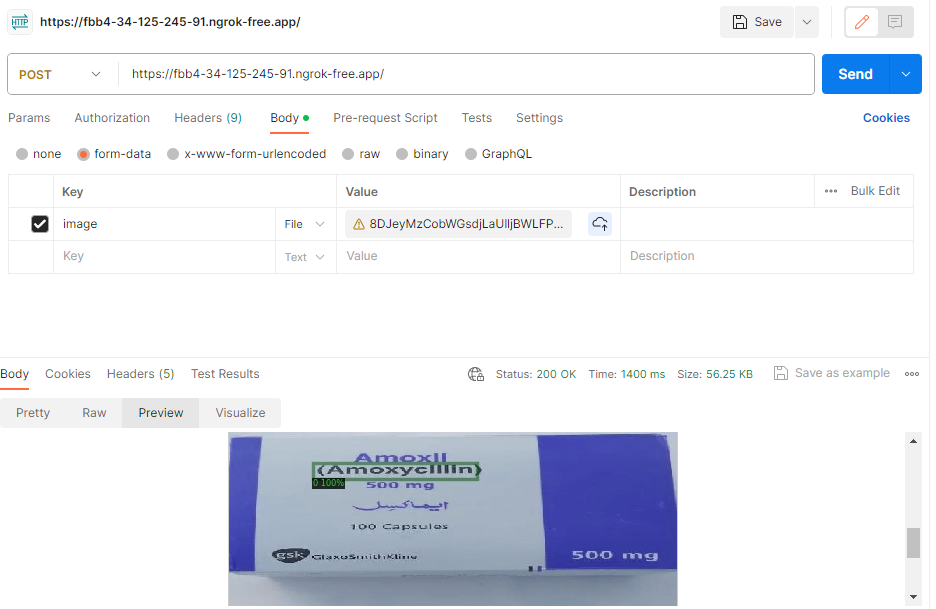

###FLask - UI:
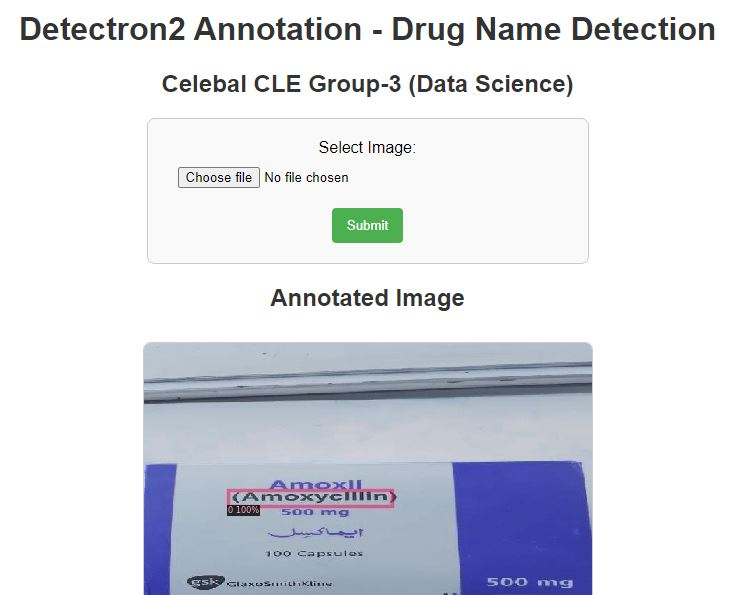

##Streamlit - UI Screenshot:
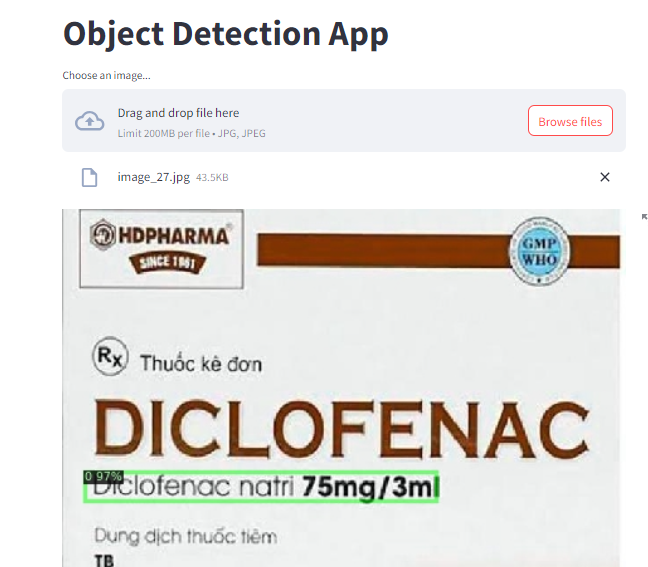